In [1]:
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow.keras import layers, losses, models, optimizers
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
from matplotlib import rcParams as rc
rc['font.size']=12
import random
from tensorflow import keras
from time import time

2022-12-12 11:20:37.367915: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-12 11:20:38.504638: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-12 11:20:38.504695: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

ImportError: initialization failed

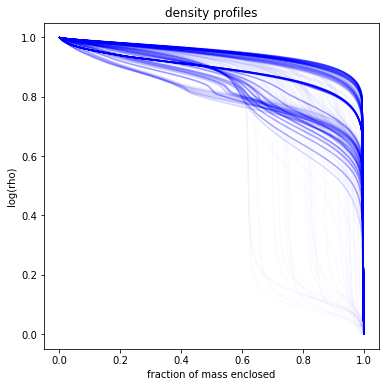

In [4]:
# dataset format:  m1, m2, p, final mass, normalized mass_enc profile,
#  central log(temperature), scaled temperature profile
data1 = np.load("../data/normalized_logrho_profiles.npy",allow_pickle=True)
valid = np.load("../data/normalized_logrho_validation_profiles.npy", allow_pickle=True)
random.seed(10)
data = random.sample(list(data1), 5000)

m1 = np.array([prof.get('m1') for prof in data], dtype='f') # initial stellar mass
m2 = np.array([prof.get('m2') for prof in data], dtype='f')
p = np.array([prof.get('p') for prof in data], dtype='f') # initial orbital period
linear_x = np.array(np.transpose([m1,m2,p]),dtype='f')

x = np.log10(linear_x) # 3d inputs for NN

linear_final_mass = np.array([prof.get('final_mass') for prof in data],dtype="f") # final stellar mass
final_mass = np.log10(linear_final_mass)

rho_min = np.array([prof.get('min_logrho') for prof in data], dtype='f')
rho_max = np.array([prof.get('max_logrho') for prof in data], dtype='f')

mass_points = data[0].get('m_arr') # x-values for normalized profiles

rho_minmax = np.array([[prof.get('min_logrho'), prof.get('max_logrho')] for prof in data], dtype='f')

# scaled density profiles
prof_true = np.array([prof.get('logrho_arr') for prof in data],dtype='f')

# plotting the density data (first 1000)
plt.figure(figsize=(6,6))
for i in range(1000):
    plt.plot(mass_points,prof_true[i],alpha=0.02,c='b')
plt.xlabel("fraction of mass enclosed")
plt.ylabel("log(rho)")
plt.title("density profiles")
plt.show()

In [5]:
valid_m1 = np.array([prof.get('m1') for prof in valid], dtype='f') # initial stellar mass
valid_m2 = np.array([prof.get('m2') for prof in valid], dtype='f')
valid_p = np.array([prof.get('p') for prof in valid], dtype='f') # initial orbital period
valid_linear_x = np.array(np.transpose([valid_m1,valid_m2,valid_p]),dtype='f')

valid_x = np.log10(valid_linear_x) # 3d inputs for NN

valid_linear_final_mass = np.array([prof.get('final_mass') for prof in valid],dtype="f") # final stellar mass
valid_final_mass = np.log10(valid_linear_final_mass)

valid_rho_min = np.array([prof.get('min_logrho') for prof in valid], dtype='f')
valid_rho_max = np.array([prof.get('max_logrho') for prof in valid], dtype='f')

valid_mass_points = valid[0].get('m_arr') # x-values for normalized profiles

valid_rho_minmax = np.array([[prof.get('min_logrho'), prof.get('max_logrho')] for prof in valid], dtype='f')

# scaled density profiles
valid_prof_true = np.array([prof.get('logrho_arr') for prof in valid],dtype='f')

In [6]:
# VALIDATION
valid_pca = PCA(n_components=6).fit(valid_prof_true) # training PCA
valid_prof_low_unscaled = valid_pca.transform(valid_prof_true) # PCA weights 

# scaling factor: st dev of each component
valid_sc = np.std(valid_prof_low_unscaled,axis=0)
valid_prof_low = valid_prof_low_unscaled/valid_sc # scaled pca weights: 6-d NN outputs
valid_reconst = valid_pca.inverse_transform(valid_prof_low*valid_sc) # PCA reconstructed data

# plt.figure()
# plt.ylabel('% Variance Explained by PCA')
# plt.xlabel('# of Features')
# plt.title('PCA Variance')
# plt.ylim(86,100)
# plt.plot(np.arange(1,len(valid_pca.components_)+1),\
#          np.cumsum(valid_pca.explained_variance_ratio_)*100)
# plt.grid()

# plt.show()

# colors = plt.cm.viridis(np.linspace(0,1,len(valid_pca.components_)))
# plt.figure()
# for i in range(len(valid_pca.components_)):
#     plt.plot(valid_mass_points,valid_pca.components_[i]+0.2*i,c=colors[i])
# plt.xlabel("fraction of mass enclosed")
# plt.ylabel("log(rho)+offset")
# plt.title("principal components of dataset")
# plt.show()

# plt.figure(figsize=(6,6))
# for i in range(1000):
#     plt.plot(valid_mass_points,valid_prof_true[i],alpha=0.02,c='b')
#     plt.plot(valid_mass_points,valid_reconst[i],alpha=0.02,c='r')
# plt.xlabel("fraction of mass enclosed")
# plt.ylabel("log(rho)")
# plt.title("PCA-reconstructed (red) vs true (blue) density profiles")
# plt.show()

Next, I reshape and reduce dimensionality of the 200-d temperature profile outputs using PCA sphering. I only use the first 6 principal components, which explain ~99% of the variance between the set of original profiles and their PCA reconstructions (as the plot below shows)

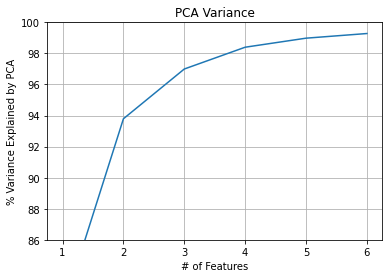

In [7]:
pca = PCA(n_components=6).fit(prof_true) # training PCA

plt.figure()
plt.ylabel('% Variance Explained by PCA')
plt.xlabel('# of Features')
plt.title('PCA Variance')
plt.ylim(86,100)
plt.plot(np.arange(1,len(pca.components_)+1),\
         np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid()

plt.show()

# colors = plt.cm.viridis(np.linspace(0,1,len(pca.components_)))
# plt.figure()
# for i in range(len(pca.components_)):
#     plt.plot(mass_points,pca.components_[i]+0.2*i,c=colors[i])
# plt.xlabel("fraction of mass enclosed")
# plt.ylabel("log(rho)+offset")
# plt.title("principal components of dataset")
# plt.show()

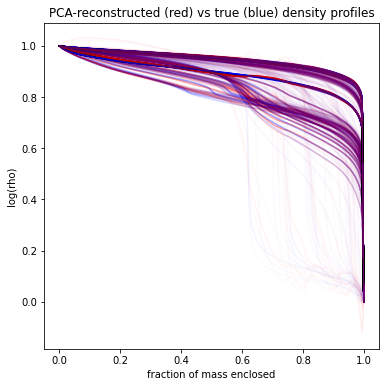

In [8]:
prof_low_unscaled = pca.transform(prof_true) # PCA weights 

# scaling factor: st dev of each component
sc = np.std(prof_low_unscaled,axis=0)
prof_low = prof_low_unscaled/sc # scaled pca weights: 6-d NN outputs
reconst = pca.inverse_transform(prof_low*sc) # PCA reconstructed data

# plotting for the first 1000 points out of 38000 because it gets too cluttered
plt.figure(figsize=(6,6))
for i in range(1000):
    plt.plot(mass_points,prof_true[i],alpha=0.02,c='b')
    plt.plot(mass_points,reconst[i],alpha=0.02,c='r')
plt.xlabel("fraction of mass enclosed")
plt.ylabel("log(rho)")
plt.title("PCA-reconstructed (red) vs true (blue) density profiles")
plt.show()

In [9]:
# Comparing true profiles to reconstructed profiles
# for i in range(30):
#     plt.plot(mass_points,prof_true[i])
#     plt.plot(mass_points, reconst[i])
#     plt.ylabel(i)
#     plt.show()
    
# 12 components gives a nearly identical reconstruction
# 6 components is a bit worse but still good, with slight deviations

My neural network consists of 6 fully-connected layers, with 2 inputs for the initial stellar mass and initial orbital periods, 
and 6 outputs. I use the Adam optimizer on a mean squared error loss function.

In [13]:
model = models.Sequential([
    layers.Dense(15,input_dim=3,activation=None),
    layers.Dense(15,input_dim=15,activation="relu"),
    layers.Dense(15,input_dim=15,activation="relu"),
    layers.Dense(15,input_dim=15,activation="tanh"),
    layers.Dense(10,input_dim=10,activation="tanh"),
    layers.Dense(10,input_dim=10,activation="tanh"),
    layers.Dense(6,input_dim=10,activation=None)
])

regress = lambda x: model(x)

In [14]:
prof_low_pred = regress(x)
loss_mse = losses.MeanSquaredError()
loss_mse(prof_low,prof_low_pred).numpy()

1.0919199

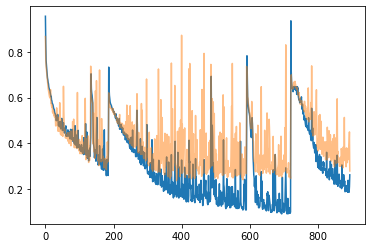

time: 477.6317958831787


In [15]:
t0 = time()
model.compile(optimizers.Adam(clipnorm=1),loss=loss_mse)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200)
history = model.fit(x,prof_low,epochs=3000,callbacks=[callback],verbose=0, validation_data=(valid_x, valid_prof_low))
plt.plot(history.history['loss'])
plt.plot(history.history["val_loss"],alpha=0.5)
plt.show()
print("time:",time()-t0)

In [16]:
prof_low_pred = regress(x)
loss_mse = losses.MeanSquaredError()
loss_mse(prof_low,prof_low_pred).numpy()

0.20846237

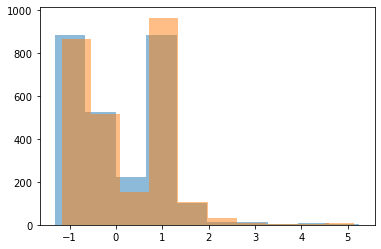

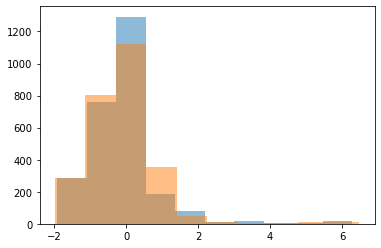

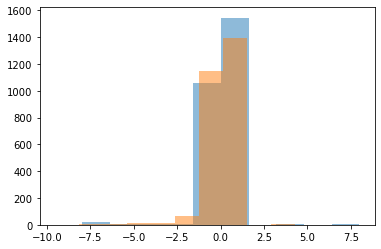

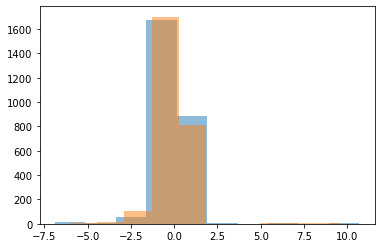

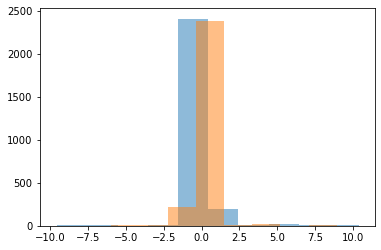

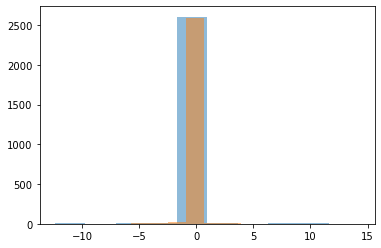

In [17]:
for i in range(6):
    plt.figure()
    plt.hist(valid_prof_low[:,i],alpha=0.5,bins=10)
    plt.hist(model(valid_x).numpy()[:,i],alpha=0.5,bins=10)
    plt.show()

# final mass

In [18]:
# model to predict final mass - 3 inputs, 1 output
model_mass = models.Sequential([
    layers.Dense(10,input_dim=3,activation=None),
    layers.Dense(10,input_dim=10,activation='relu'),
    layers.Dense(10,input_dim=10,activation='tanh'),
    layers.Dense(10,input_dim=10,activation='tanh'),
    layers.Dense(10,input_dim=10,activation='tanh'),
    layers.Dense(10,input_dim=10,activation='tanh'),
    layers.Dense(1,activation=None)
])

regress_mass = lambda x: model_mass(x)

mpred = regress_mass(x)

loss_mse = losses.MeanSquaredError()
loss_mse(final_mass,mpred).numpy()

1.3486215

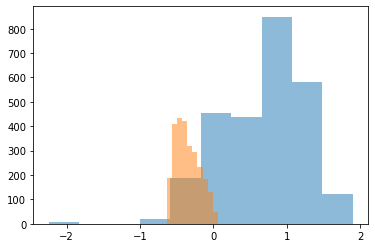

In [19]:
plt.figure()
plt.hist(valid_final_mass,alpha=0.5)
plt.hist(model_mass(valid_x).numpy(),alpha=0.5)
plt.show()

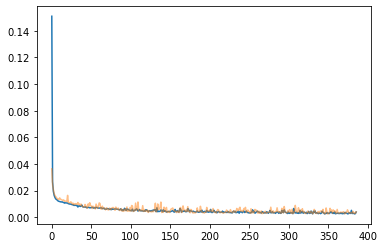

5000/1 - 0s - loss: 0.0025
191.8428659439087


In [20]:
t0 = time()
model_mass.compile(optimizers.Adam(clipnorm=1),loss=loss_mse,lr=0.001)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=40)
history = model_mass.fit(x,final_mass,epochs=2000,\
                         callbacks=[callback],verbose=0,\
                        validation_data =(valid_x,valid_final_mass))
plt.plot(history.history['loss'])
plt.plot(history.history["val_loss"],alpha=0.5)
plt.show()

model_mass.evaluate(x,final_mass,verbose=2)
print("time",time()-t0)

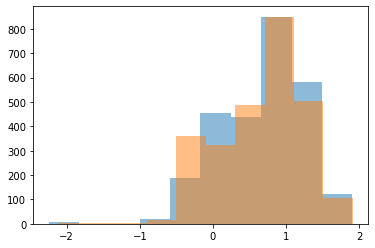

In [21]:
plt.hist(valid_final_mass,alpha=0.5,bins=10)
plt.hist(model_mass(valid_x).numpy(),alpha=0.5,bins=10)
plt.show()

# min/max density

In [22]:
# 3 inputs and 2 outputs (min/max logrho)
model_rho = models.Sequential([
    layers.Dense(10,input_dim=3,activation='relu'),
    layers.Dense(10,input_dim=10,activation='relu'),
    layers.Dense(10,input_dim=10,activation='tanh'),
    layers.Dense(10,input_dim=10,activation='tanh'),
    layers.Dense(10,input_dim=10,activation='tanh'),
    layers.Dense(10,input_dim=10,activation='tanh'),
    layers.Dense(2,activation=None)
])

regress_rho = lambda x: model_rho(x)

rhopred = regress_rho(x)

loss_mse = losses.MeanSquaredError()
loss_mse(rho_minmax,rhopred).numpy()

41.86247

In [ ]:
t0 = time()
model_rho.compile(optimizers.Adam(clipnorm=1),loss="mse")
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
history = model_rho.fit(x,rho_minmax,epochs=2000,\
                         callbacks=[callback],verbose=0,
                       validation_data =(valid_x,valid_rho_minmax))
plt.plot(history.history['loss'])
plt.plot(history.history["val_loss"],alpha=0.5)
plt.show()

model_rho.evaluate(x,rho_minmax,verbose=2)
print("time:",time()-t0)

# profile predictions

My final prediction brings together all 3 NNs to reconstruct the temperature profile prediction for any new binary in this 2d slice of parameter space. 

In [ ]:
def pred_profiles(lin_x):
    x = np.log10(lin_x)
    final_log_masses = regress_mass(x).numpy()
    final_linear_masses = 10**final_log_masses
    
    min_rho = np.array(regress_rho(x)[:,0])
    max_rho = np.array(regress_rho(x)[:,1])
    
    scaled_pca_weights = regress(x)
    norm_profiles = pca.inverse_transform(scaled_pca_weights*sc)
    
    density_profiles = norm_profiles*(max_rho[:,np.newaxis]-min_rho[:,np.newaxis]) + min_rho[:,np.newaxis]
    xcoords = mass_points*final_linear_masses[:,np.newaxis]

    return xcoords,density_profiles

In [ ]:
def pred(log_x):
    x = log_x
    final_log_masses = regress_mass(x).numpy()
    final_linear_masses = 10**final_log_masses
    
    min_rho = np.array(regress_rho(x)[:,0])
    max_rho = np.array(regress_rho(x)[:,1])
    
    scaled_pca_weights = regress(x)
    norm_profiles = pca.inverse_transform(scaled_pca_weights*sc)
    
    density_profiles = norm_profiles*(max_rho[:,np.newaxis]-min_rho[:,np.newaxis]) + min_rho[:,np.newaxis]
    xcoords = mass_points*final_linear_masses[:,np.newaxis]

    return xcoords,density_profiles

In [ ]:
testpts = [[0.1,1,1],[1,1,8],[0.2,1,20]]
testpts1 = [[2, 6, 24], [2, 2, 12], [0.8, 2, 24]]
xcoords,profiles = pred_profiles(testpts)
plt.figure()
for i in range(len(xcoords)):
    plt.plot(xcoords[i][0],profiles[i],label =\
             "m1="+str(testpts[i][0])+", m2="+str(testpts[i][1])+", p="+str(testpts[i][2]))
    plt.xlabel("mass enclosed, solar masses")
    plt.ylabel("predicted log(rho profile)")
plt.title("NN-predicted density profiles for 3 different binaries")
plt.legend()
plt.show()

In [ ]:
testpts = [[61.0721973, 11.0880684, 104.6672966]]
xcoords1,profiles1 = pred_profiles(testpts)
# profiles1 = np.log10(profiles1)
plt.figure()
plt.plot(xcoords1[0][0],profiles1[0],label = "pred")
plt.plot(mass_points*valid_linear_final_mass[2], valid_prof_true[2]*(valid_rho_max[2]-valid_rho_min[2])+valid_rho_min[2], label="true")
plt.xlabel("mass enclosed, solar masses")
plt.ylabel("predicted log(rho profile)")
#plt.title("NN-predicted density profiles for 3 different binaries")
plt.legend()
plt.show()
valid_linear_x[2]

In [ ]:
testpts = [[0.81399655, 4.9406686, 0.571922]]
xcoords2,profiles2 = pred_profiles(testpts)
# profiles2 = np.log10(profiles2)
plt.figure()
plt.plot(xcoords2[0][0],profiles2[0],label = "pred")
plt.plot(mass_points*valid_linear_final_mass[3], valid_prof_true[3]*(valid_rho_max[3]-valid_rho_min[3])+valid_rho_min[3], label="true")
plt.xlabel("mass enclosed, solar masses")
plt.ylabel("predicted log(rho profile)")
#plt.title("NN-predicted density profiles for 3 different binaries")
plt.legend()
plt.show()
valid_linear_x[3]


In [ ]:
testpts = [[55.17751, 3.7443938, 51.425518]]
xcoords3,profiles3 = pred_profiles(testpts)
# profiles3 = np.log10(profiles3)
plt.figure()
plt.plot(xcoords3[0][0],profiles3[0],label = "pred")
plt.plot(mass_points*valid_linear_final_mass[1000], valid_prof_true[1000]*(valid_rho_max[1000]-valid_rho_min[1000])+valid_rho_min[1000], label="true")
plt.xlabel("mass enclosed, solar masses")
plt.ylabel("predicted log(rho profile)")
#plt.title("NN-predicted density profiles for 3 different binaries")
plt.legend()
plt.show()
valid_linear_x[1000]


In [ ]:
testpts = [[32.53242, 5.285393, 1.3682235]]
xcoords4,profiles4 = pred_profiles(testpts)
# profiles4 = np.log10(profiles4)
plt.figure()
plt.plot(xcoords4[0][0],profiles4[0],label = "pred")
plt.plot(mass_points*valid_linear_final_mass[2000], valid_prof_true[2000]*(valid_rho_max[2000]-valid_rho_min[2000])+valid_rho_min[2000], label="true")
plt.xlabel("mass enclosed, solar masses")
plt.ylabel("predicted log(rho profile)")
plt.title("NN-predicted density profiles for 3 different binaries")
plt.legend()
plt.show()
valid_linear_x[2000]


In [ ]:
def eval_model(i):
    testpts = valid_x[i]
    xcoords, profiles = pred(testpts)
    
    true_x = mass_points*valid_linear_final_mass[i]
    true_y = valid_prof_true[i]*(valid_rho_max[i]-valid_rho_min[i])+valid_rho_min[i]
    
    plt.figure()
    plt.plot(true_x, true_y, label="true")
    plt.plot(xcoords[0][0],profiles[0],label="pred")
    plt.xlabel("mass enclosed, solar masses")
    plt.ylabel("predicted log(rho profile)")
    plt.title("NN-predicted density profiles for a validation profile")
    plt.legend()
    plt.show()


In [ ]:
for i in [2,3,1000,2000]:
    print(i)
    eval_model(i)

## next steps

model evaluation

compare different predictions a la Monica

ask which profiles are most important

temperature

more infrastructure

isolated networks plus one network for correlations

fine tune final mass model